In [1]:
suppressMessages({
    # library(splines)
    library(fields)
    library(splines2)
    library(nimble)
    library(vegan)
    library(ncdf4)
    library(httpgd)
    hgd()
    rm(list = ls())
})

httpgd server running at:
  http://127.0.0.1:33025/live?token=Bwc2ZL6x


[1] "Row sums:"
 Site_1  Site_2  Site_3  Site_4  Site_5  Site_6  Site_7  Site_8  Site_9 Site_10 
      1       1       1       1       1       1       1       1       1       1 


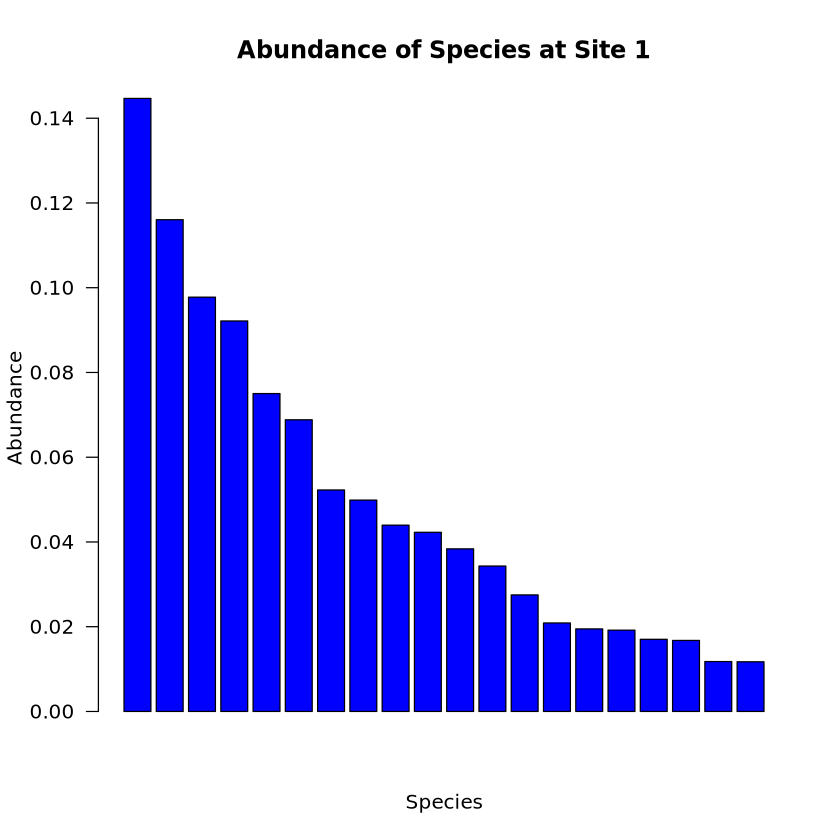

In [45]:
#----------------------------------------------------------------
# Create synthetic eDNA data
#----------------------------------------------------------------

set.seed(123)  # Set seed for reproducibility

no_sites <- 10
no_species <- 20

# Create a random OTU table with a standard abundance distribution
otu_table <- matrix(rlnorm(no_sites * no_species, meanlog = 0, sdlog = 1), nrow = no_sites, ncol = no_species)

# Normalize to get relative abundances
otu_table <- otu_table / rowSums(otu_table)

# Convert to data frame for better readability
otu_table <- as.data.frame(otu_table)
colnames(otu_table) <- paste0("Species_", 1:no_species)
rownames(otu_table) <- paste0("Site_", 1:no_sites)

# print(otu_table)
# Order species by reducing abundance
sorted_otu_table <- t(apply(otu_table, 1, function(x) sort(x, decreasing = TRUE)))

# Set the background color to white
par(bg = "white")
# Plot the first row
barplot(as.numeric(sorted_otu_table[1, ]), main = "Abundance of Species at Site 1", xlab = "Species", ylab = "Abundance", las = 2, col = "blue")

# Sum the rows and columns
row_sums <- rowSums(otu_table)

# Print the sums
print("Row sums:")
print(row_sums)


In [ ]:
#----------------------------------------------------------------
# load in data
#----------------------------------------------------------------

midnor <- nc_open("/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc")

sinmod_data <- gin

# Obtain the grid information
xc = dim(ncvar_get(gin, "xc"))[1]
yc = dim(ncvar_get(gin, "yc"))[1]

# Obtain depth information to check for land
depth = ncvar_get(sinmod_data, "depth")

# Print
print(paste("Grid size: ", xc, "x", yc))

[1] "Grid size:  950 x 555"


[1] 800

In [ ]:
# Set random seed
set.seed(1)

# Randomly sample the grid

# Get the value at (1,1) (which is considered invalid)
invalid_value <- depth[1, 1]

# Exclude locations where depth is equal to the value at (1,1)
valid_locations <- which(depth != invalid_value, arr.ind = TRUE)

sampled_locations <- valid_locations[sample(nrow(valid_locations), no_sites), ]

# Label sampled_locations columns 'x' and 'y'
colnames(sampled_locations) <- c('x', 'y')

# List all variables in the NetCDF file
variables <- names(sinmod_data$var)
print(variables)

# Obtain the SINMOD env data at sampled locations
# We will choose temperature, salinity, u_velocity, v_velocity
env_variables <- c("temperature", "salinity", "u_velocity", "v_velocity") # Can add "elevation" if needed

# Create an empty data frame to store the SINMOD data for multiple variables
sinmod_df <- data.frame(matrix(NA, nrow = no_sites, ncol = length(env_variables)))
colnames(sinmod_df) <- env_variables  # Assign variable names as column names

# Fetch data for each variable one by one at the sampled locations (avoid loading entire dataset)
for (j in 1:length(env_variables)) {
    var <- env_variables[j]
    
    # Get dimensions of the variable (3D or 4D)
    var_dims <- length(sinmod_data$var[[var]]$dim)
    
    if (var_dims == 3) {
        # Fetch data for 3D variables like "elevation"
        for (i in 1:no_sites) {
            x <- sampled_locations[i, 1]  # x-coordinate
            y <- sampled_locations[i, 2]  # y-coordinate
            # Fetch data at the specific location
            sinmod_df[i, j] <- ncvar_get(sinmod_data, var, start = c(x, y, 1), count = c(1, 1, 1))
        }
    } else {
        # Fetch data for 4D variables like "temperature"
        for (i in 1:no_sites) {
            x <- sampled_locations[i, 1]  # x-coordinate
            y <- sampled_locations[i, 2]  # y-coordinate
            # Fetch data at the specific location and time/depth slice (time=0, depth=0)
            sinmod_df[i, j] <- ncvar_get(sinmod_data, var, start = c(x, y, 1, 1), count = c(1, 1, 1, 1))
        }
    }
} 

# Print the resulting data frame
print(sinmod_df)

# Save the resulting data frame as a CSV file
write.csv(sinmod_df, "../../data/synthetic/midnor.csv", row.names = FALSE)

# Save the sampled locations as a CSV file
write.csv(sampled_locations, "../../data/synthetic/sampled_locations.csv", row.names = FALSE)

# Save the eDNA data (otu_table) as a CSV file
write.csv(otu_table, "../../data/synthetic/otu_table.csv", row.names = TRUE)


 [1] "grid_mapping"    "LayerDepths"     "depth"           "DXxDYy"         
 [5] "u_velocity"      "v_velocity"      "elevation"       "temperature"    
 [9] "salinity"        "ice_thickness"   "ice_compactness" "salinity_ice"   
   temperature salinity   u_velocity   v_velocity
1     7.882015 32.58995  0.136234626 -0.002197333
2     8.266854 34.67284  0.101321451  0.013550218
3     8.646138 35.27482  0.048219245  0.012817774
4     8.473159 34.90326 -0.001220740  0.099124119
5     8.814356 33.56502  0.380870998  0.213629566
6     7.820917 34.19218  0.248420667  0.300546281
7     7.379742 35.12146 -0.371471297  0.002441481
8     9.017487 34.17234  0.595965452 -0.031250954
9     8.139897 32.60750 -0.009155553 -0.008667257
10    8.558855 35.24888  0.259041108 -0.021851253


In [ ]:
# Get the shape of the 'temperature' variable
temperature_shape <- sinmod_data$var[["temperature"]][["size"]]
print(temperature_shape)

[1] 950 555  50 365
